In [1]:
! ls /scratch/Projects/IMMUNEX/segmentation/bin2cell/

bin2cell_output  bin2cell_output_he0.01_gex0.05  bin2cell_output_he0005_gex005


In [1]:
# import sys
# sys.path.append("/opt/Banksy_py")
# import banksy as banksy
# import time; import random

# from banksy.initialize_banksy import initialize_banksy
# from banksy.run_banksy import run_banksy_multiparam
# from banksy_utils.color_lists import spagcn_color
# from banksy_utils.plot_utils import plot_qc_hist, plot_cell_positions
# from banksy_utils.load_data import load_adata, display_adata
# from banksy_utils.filter_utils import filter_cells
# from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

# Load the data
sample_id = "IMMUNEX002"
adata = sc.read(os.path.join('./', f"{sample_id}_clustered_leiden_allcells.h5ad"))

# adata = sc.read(f"/scratch/Projects/IMMUNEX/segmentation/bin2cell/bin2cell_output_he0.01_gex0.05/{sample_id}/adata_processed.h5ad")
adata.raw = adata
adata.uns['sample_id'] = sample_id
adata

AnnData object with n_obs × n_vars = 413271 × 5088
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'nn_30 leiden_0.2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'bin2cell', 'hvg', 'log1p', 'neighbors', 'nn_30 leiden_0.2', 'nn_30 leiden_0.2_colors', 'pca', 'rank_genes_groups', 'sample_id', 'sample_metadata', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
# Load the metadata
metadata = pd.read_csv("~/rawdata/IMMUNEX/data/VisiumHD_18_2024_NSCLC.csv")

metadata_sample = metadata[metadata['Sample_code'] == sample_id]
adata.uns["sample_metadata"] = metadata_sample.iloc[0].to_dict()

display(adata.obs.head()) # Display the first few rows of the observation data (cell metadata)

,n_counts,n_bins,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,nn_30 leiden_0.2
1,395.186130,57.0,272,5.609472,395.186130,5.981884,39.467897,59.435549,86.235488,100.0,51.186860,3.954831,12.952595,1
10,323.150702,55.0,211,5.356586,323.150702,5.781209,41.637753,64.939660,97.689955,100.0,34.707724,3.575367,10.740414,0
10000,224.943907,24.0,142,4.962845,224.943907,5.420287,51.217193,81.990916,100.000000,100.0,14.664284,2.751383,6.519085,0
100000,104.492788,19.0,75,4.330733,104.492788,4.658643,79.332736,100.000000,100.000000,100.0,7.072833,2.088504,6.768728,1
100001,51.549135,9.0,46,3.850148,51.549135,3.961749,100.000000,100.000000,100.000000,100.0,2.955435,1.375091,5.733239,1


## Cropped viz

In [7]:
adata_cells = adata

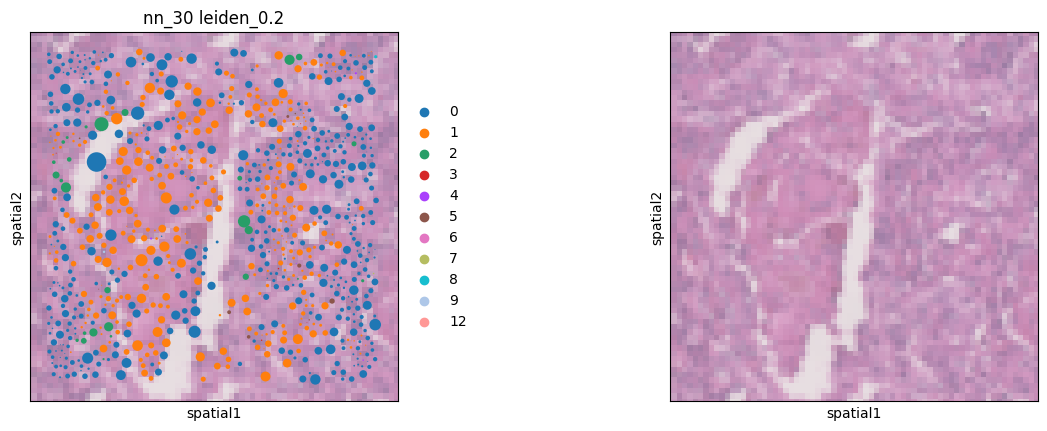

In [9]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
adata_cells = adata.copy()
crop_axis_fraction = 0.05  # how much to crop around the center

# Get spatial coordinates
spatial_coords = adata_cells.obsm['spatial'].copy()

# Compute coordinate bounds and center
x_min, x_max = np.min(spatial_coords[:, 0]), np.max(spatial_coords[:, 0])
y_min, y_max = np.min(spatial_coords[:, 1]), np.max(spatial_coords[:, 1])
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Define crop bounds around center
x0 = center_x - (x_max - x_min) * crop_axis_fraction / 2
x1 = center_x + (x_max - x_min) * crop_axis_fraction / 2
y0 = center_y - (y_max - y_min) * crop_axis_fraction / 2
y1 = center_y + (y_max - y_min) * crop_axis_fraction / 2

# Find cells within crop
within_crop = (
    (spatial_coords[:, 0] >= x0) & (spatial_coords[:, 0] <= x1) &
    (spatial_coords[:, 1] >= y0) & (spatial_coords[:, 1] <= y1)
)
adata_cropped = adata_cells[within_crop, :].copy()

# Normalize n_bins to define spot sizes (you can adjust scaling)
sizes = adata_cropped.obs['n_bins']
sizes_normalized = 10 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cropped,
    color=['nn_30 leiden_0.2',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)


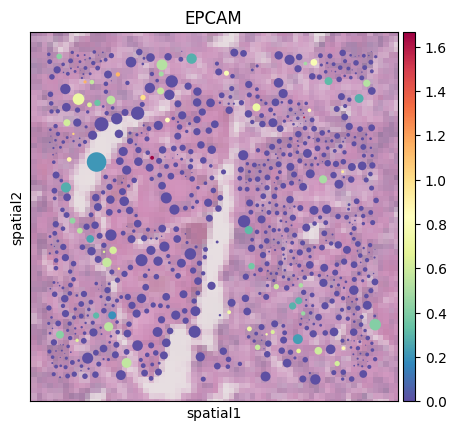

In [11]:

sc.pl.spatial(
    adata_cropped,
    color=['EPCAM'],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)

In [19]:
c7 = adata_cells.obs['nn_30 leiden_0.2'] == '7'
adata_c7 = adata_cells[c7]
adata_c7


View of AnnData object with n_obs × n_vars = 1733 × 5088
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'nn_30 leiden_0.2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'bin2cell', 'hvg', 'log1p', 'neighbors', 'nn_30 leiden_0.2', 'nn_30 leiden_0.2_colors', 'pca', 'rank_genes_groups', 'sample_id', 'sample_metadata', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

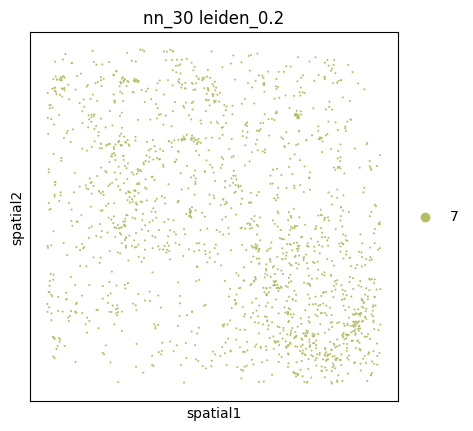

In [29]:
sc.pl.spatial(
    adata_c7,
    color=['nn_30 leiden_0.2'],
    cmap='Spectral_r',
    alpha_img=0.6,  # has no effect since img=None
    show=True,
    size=20,
    img_key=None  # this disables the tissue image
)


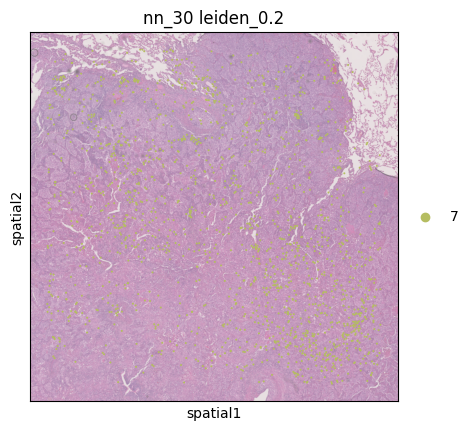

KeyError: 'MADCAM1'

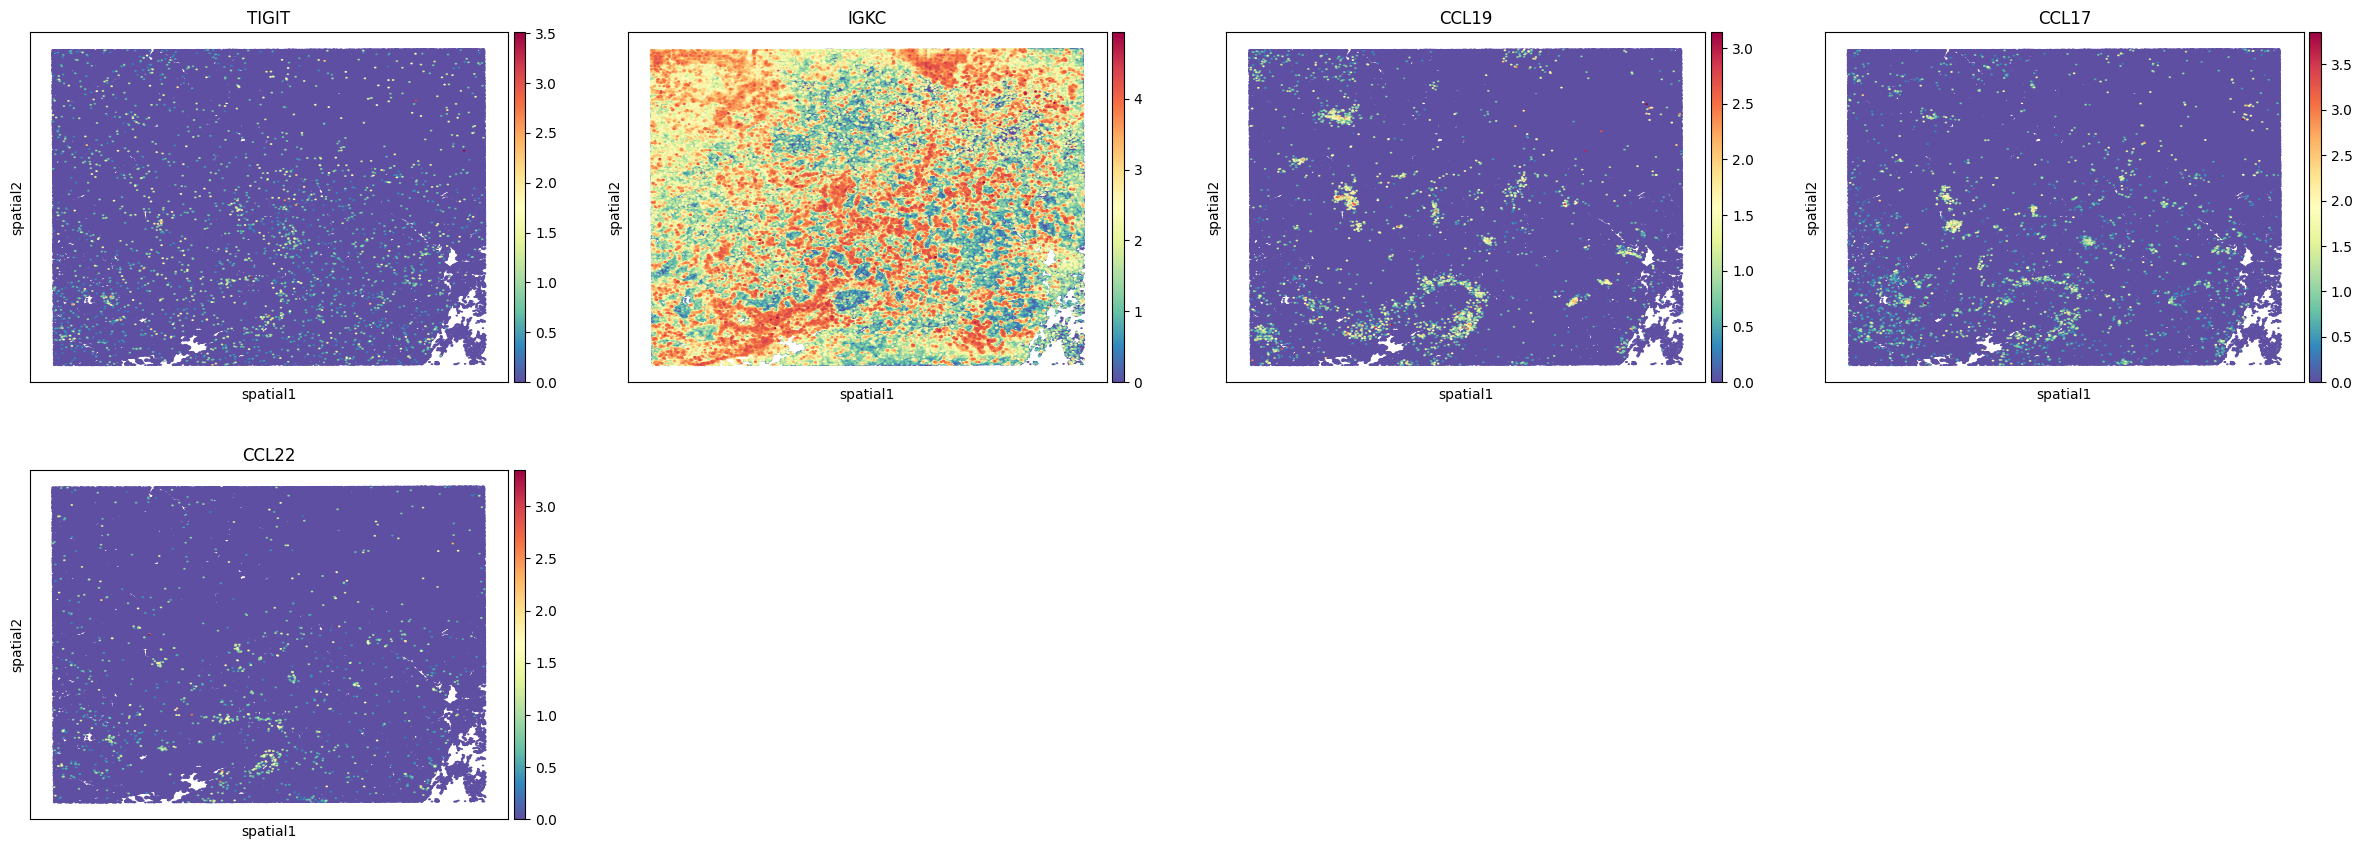

In [27]:

sc.pl.spatial(
    adata_c7,
    color=['nn_30 leiden_0.2'],
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True,
    size = 20,
    img=None,
)

sc.pl.spatial(
    adata,
    color=['TIGIT','IGKC','CCL19','CCL17','CCL22','MADCAM1'],
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True,
    size = 20
)